## Notebook Description

- Expected structure in original images dataset
    ROOT_DATA: path where the image data is stored. \
                Expected data structure within the ROOT directory\
                IQ_OTHNCCD [ref1](https://data.mendeley.com/datasets/bhmdr45bh2/1) [ref2](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset)\
                    ├───Bengin cases\
                    ├───Malignant cases\
                    └───Normal cases

- Exploring dataset `IQ_OTHNCCD_LungCancer`
- Playing around with CLAHE

## Import libraries

In [1]:
import os
import glob
import re

import numpy as np 
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

## Config

In [2]:
class cfg: 
    #==================================================
    # THIS NOTEBOOK ID
    NB_ID = "FR_t01e01nb01v1"

    #==================================================
    # ROOT DATA SOURCE
    ROOT_DATA = os.path.join('..', '..', '..', 
                             'data', 
                             '01_original', 
                             'IQ_OTHNCCD_LungCancer', 
                             'IQ_OTHNCCD')
    

## Utility Functions 

### create_img_d_meta()

In [3]:
def create_img_d_meta(ROOT_DATA): 

    """
    Description: 
    ------------
        this function find all the images path and create a 
            pd.DataFrame() d_meta for easy filetering and 
            selection of the images for each experiment. 
            This function is optimize for this dataset IQ_OTHNCCD

    Pararmentter
    ------------
        ROOT_DATA: path where the image data is stored. 
                    Expected data structure within the ROOT directory
                    IQ_OTHNCCD
                        ├───Bengin cases
                        ├───Malignant cases
                        └───Normal cases


    Return: 
    --------
        d_meta: pd.DataFrame of metadata of images with columns : 
            'path', 'fname', 'img_n_order', 'cls_name', 'y_true
                col 'img_n_order' indicates the order of the image provided by the 
                                 data creators 

            map_dict use for y_true 
            map_dict = {'Normal cases': 0, 
                        'Bengin cases': 1, 
                        'Malignant cases': 2, 
                        }
        
    """

    #___________________________
    # Find all path 
    all_img_path_lst = glob.glob(os.path.join(ROOT_DATA, '*', '*.jpg'))

    #___________________________
    # adding meta to each image path. 
    store_d = []
    for p in all_img_path_lst:
    
        fname = os.path.split(p)[1]
        cls_name = os.path.split(os.path.split(p)[0])[1]
        img_n_order = int(re.findall(r'\((.*?)\)', fname)[0])

        #__________
        # Images in IQ_OTHNCCD are gray scale
        img = cv2.imread(filename=p, flags=0)
        original_shape = img.shape
    
        #------
        # Store data 
        store_d.append([p, 
                        fname, 
                        img_n_order, 
                        cls_name, 
                        original_shape,
                       ])
        #------
        #___________________________________________
        # break
    #_______________________________________________
    # Creating d_meta
    d_meta = pd.DataFrame(store_d, columns=["path_original", "fname", "img_n_order", "cls_name", "img_shape_original"])
    d_meta["img_shape_original"] = d_meta["img_shape_original"].apply(lambda x: f"{x[0]}x{x[1]}" if isinstance(x, tuple) else str(x))
    map_dict = {'Normal cases': 0, 
                'Bengin cases': 1, 
                'Malignant cases': 2
               }
    d_meta['cls_id'] = d_meta['cls_name'].map(map_dict)
    d_meta["img_ID"] = "cls" + d_meta['cls_id'].astype(str) + "_order" + d_meta["img_n_order"].astype(str)
    d_meta.sort_values(by=["cls_id", "img_n_order",], ignore_index=True, inplace=True)
    #_______________________________________________
    return d_meta


### apply_clahe()

In [4]:
def apply_clahe(image, clipLimit=2.0, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(image)

### VIZ_CLAHE()

In [5]:
def VIZ_CLAHE(img_id, d_meta, clipLimit=2.0, tileGridSize=(8, 8), ): 
    c1 = d_meta["img_ID"] == img_ID
    path = d_meta[c1]["path_original"].item()
    img1 = cv2.imread(filename=path, flags=0)
    
    # Apply CLAHE
    def apply_clahe(img, clipLimit=2.0, tileGridSize=(8, 8)):
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        return clahe.apply(img)
    
    img2 = apply_clahe(img1, clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Compute percentage histograms
    def calc_hist_percent(img):
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        return hist / hist.sum() * 100
    
    hist1 = calc_hist_percent(img1)
    hist2 = calc_hist_percent(img2)
    max_percent = max(hist1.max(), hist2.max()) * 1.05
    
    # Create a 4x2 grid
    fig = plt.figure(figsize=(7, 8))
    gs = GridSpec(4, 2, width_ratios=[1.5, 1])
    
    # Image 1: spans rows 0 and 1, column 0
    ax_img1 = fig.add_subplot(gs[0:2, 0])
    ax_img1.imshow(img1, cmap='gray', aspect='auto', vmin=0, vmax=255)
    ax_img1.set_title(f"ImgID: {img_ID}")
    ax_img1.axis('off')
    
    # Histogram 1: row 1, col 1
    ax_hist1 = fig.add_subplot(gs[1, 1])
    ax_hist1.plot(hist1, color='black')
    ax_hist1.set_title("Histogram 1 (Percentage)")
    ax_hist1.set_xlim([0, 256])
    ax_hist1.set_ylim([0, max_percent])
    ax_hist1.set_xlabel("Pixel Intensity", fontsize=9)
    ax_hist1.set_ylabel("Percentage (%)", fontsize=9)
    ax_hist1.grid(True)
    ax_hist1.tick_params(labelsize=8)
    ax_hist1.spines['top'].set_visible(False)
    ax_hist1.spines['right'].set_visible(False)
    
    # Image 2: spans rows 2 and 3, column 0
    ax_img2 = fig.add_subplot(gs[2:4, 0])
    ax_img2.imshow(img2, cmap='gray', aspect='auto', vmin=0, vmax=255)
    ax_img2.set_title(f"CLAHE: clipLimit={clipLimit} | tileGridSize={tileGridSize}")
    ax_img2.axis('off')
    
    # Histogram 2: row 3, col 1
    ax_hist2 = fig.add_subplot(gs[3, 1])
    ax_hist2.plot(hist2, color='black')
    ax_hist2.set_title("Histogram 2 (Percentage)")
    ax_hist2.set_xlim([0, 256])
    ax_hist2.set_ylim([0, max_percent])
    ax_hist2.set_xlabel("Pixel Intensity", fontsize=9)
    ax_hist2.set_ylabel("Percentage (%)", fontsize=9)
    ax_hist2.grid(True)
    ax_hist2.tick_params(labelsize=8)
    ax_hist2.spines['top'].set_visible(False)
    ax_hist2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## Prototyping

In [6]:
fname = "Normal case (328) .jpg"
fname = "Normal case (328).jpg"
fname = "Normal case (328) - .jpg"
fname = "Normal case(328) - .jpg"
fname = "Normal case ( 328) - .jpg"
fname = "Normal case ( 328 ) - .jpg"
img_n_order = int(re.findall(r'\((.*?)\)', fname)[0])
print(img_n_order)

328


## Create Images Metadata

In [7]:
d_meta = create_img_d_meta(ROOT_DATA=cfg.ROOT_DATA)
d_meta.info()
d_meta.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path_original       1097 non-null   object
 1   fname               1097 non-null   object
 2   img_n_order         1097 non-null   int64 
 3   cls_name            1097 non-null   object
 4   img_shape_original  1097 non-null   object
 5   cls_id              1097 non-null   int64 
 6   img_ID              1097 non-null   object
dtypes: int64(2), object(5)
memory usage: 60.1+ KB


,path_original,fname,img_n_order,cls_name,img_shape_original,cls_id,img_ID
0,../../../data/01_original/IQ_OTHNCCD_LungCance...,Normal case (1).jpg,1,Normal cases,512x512,0,cls0_order1
1,../../../data/01_original/IQ_OTHNCCD_LungCance...,Normal case (2).jpg,2,Normal cases,512x512,0,cls0_order2
2,../../../data/01_original/IQ_OTHNCCD_LungCance...,Normal case (3).jpg,3,Normal cases,512x512,0,cls0_order3


In [8]:
d_meta["img_ID"].nunique(), d_meta.shape

(1097, (1097, 7))

## EDA: Exploration Data Analysis

### Img Count and original dimension per class

In [9]:
d_img_cnt = d_meta.groupby(["cls_name", "img_shape_original",])\
                .agg({"cls_id":"count"})\
                .rename(columns={"cls_id":"img_count"},)\
                .reset_index()
d_img_cnt 

,cls_name,img_shape_original,img_count
0,Bengin cases,512x512,120
1,Malignant cases,404x511,1
2,Malignant cases,512x512,501
3,Malignant cases,512x623,31
4,Malignant cases,512x801,28
5,Normal cases,331x506,1
6,Normal cases,512x512,415


In [10]:
d_img_cnt["cls_name"].unique()

array(['Bengin cases', 'Malignant cases', 'Normal cases'], dtype=object)

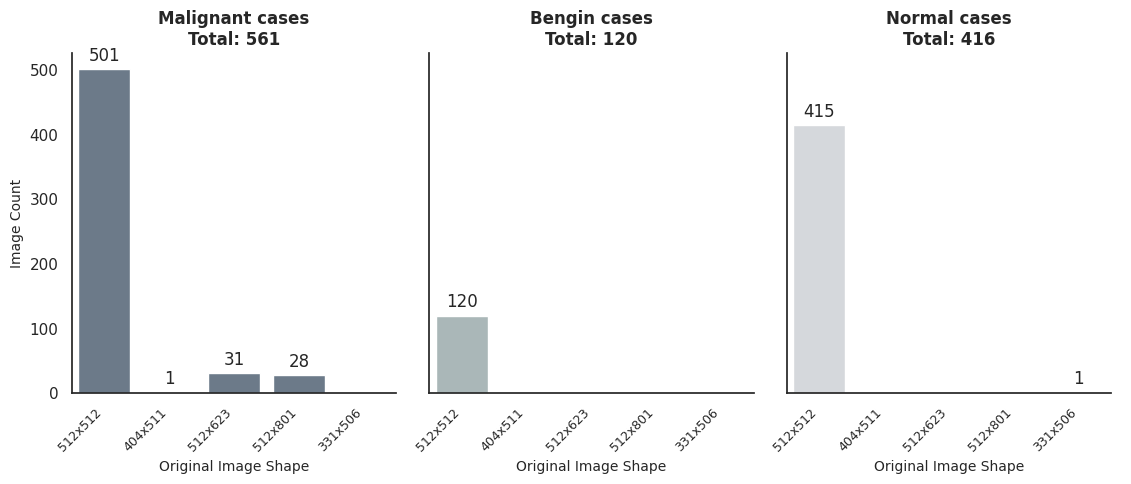

In [13]:
#_________________
# SET PLOT THEME
# sns.set_theme(style="whitegrid")
# sns.set_theme(style="darkgrid")
# sns.set_theme(style="ticks")
sns.set_theme(style="white")

#_____________________
# Total image count per class 
totals = d_img_cnt.groupby("cls_name")["img_count"].sum().to_dict()

#_____________________
# Class color


# color_map = {
#     "Bengin cases": "#444444",     # dark gray
#     "Malignant cases": "#888888",  # medium gray
#     "Normal cases": "#BBBBBB",     # light gray
# }


color_map = {
    "Malignant cases": "#6C7A89",  # muted blue-gray
    "Bengin cases": "#AAB7B8",  # silver gray
    "Normal cases": "#D5D8DC",  # pale gray-blue
}


# color_map = {
#     "Bengin cases": "#003f5c",  # navy
#     "Malignant cases": "#7a5195",  # muted purple
#     "Normal cases": "#ef5675",  # coral
# }


#____________________
custom_order = ["Malignant cases", "Bengin cases", "Normal cases"]
g = sns.catplot(
    data=d_img_cnt, 
    kind="bar",
    x="img_shape_original", 
    y="img_count",
    col="cls_name",
    col_order=custom_order,
    height=5,         # height of each subplot (in inches)
    aspect=.75,       # width = height * aspect
    color="gray",  # placeholder
    # dodge=False  # bars won't be split
)

#_____________________
# Loop through each subplot (one per 'cls_name')
for ax in g.axes.flat:
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(
            f'{int(height)}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom', 
            fontsize=12,
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

#_____________________
# Re-color each bar manually
for ax, col_val in zip(g.axes.flat, g.col_names):
    for bar in ax.patches:
        bar.set_facecolor(color_map[col_val])
#_____________________
# Adding total to each subtitle 
for ax, col_val in zip(g.axes.flat, g.col_names):
    total = totals.get(col_val, 0)
    ax.set_title(f"{col_val}\nTotal: {total}", fontsize=12, weight='bold')

#_____________________
g.set_axis_labels("Original Image Shape", "Image Count", fontsize=10)
# g.despine(left=True)
plt.tight_layout()

#___________
# SAVE IMAGE FOR REPORT 
img_name = f"{cfg.NB_ID}_img_count_barplot.png"
# g.savefig(img_name, dpi=300)  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
plt.show()

In [12]:
561+120+416

1097

## Image Gray scale - No loss of info 

In [14]:
img_ID = "cls0_order11"
c1 = d_meta["img_ID"] == img_ID
path = d_meta[c1]["path_original"].item()
#_________________
img_to_gray = cv2.imread(filename=path, flags=0) 
img_unchange = cv2.imread(filename=path, flags=cv2.IMREAD_UNCHANGED)
img_unchange = cv2.cvtColor(img_unchange, cv2.COLOR_BGR2RGB)

In [15]:
img_unchange.shape, img_to_gray.shape

((512, 512, 3), (512, 512))

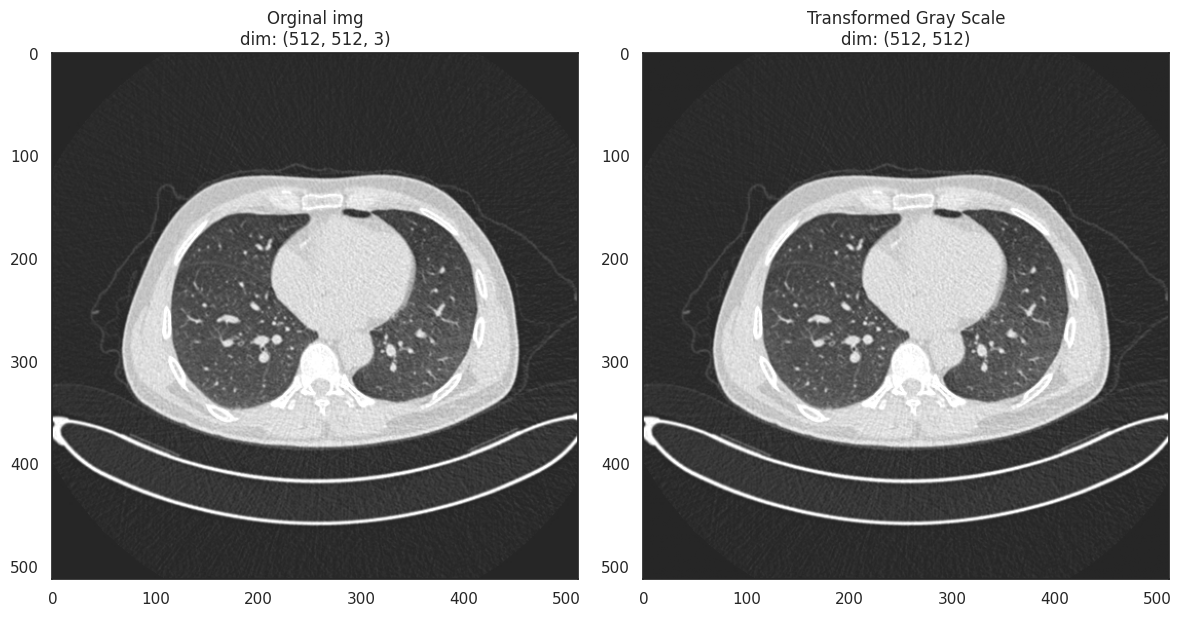

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs = axs.ravel() # original axs expect 2dimension coordinate axs[i,j] | change to 1D
imgs = [img_unchange, img_to_gray,]
im_name = ["Orginal img", "Transformed Gray Scale",]
for r_id, im in enumerate(imgs): 
    
    
    
    axs[r_id].imshow(im, cmap='gray', vmin=0, vmax=255)
    axs[r_id].set_title(f"{im_name[r_id]}\ndim: {im.shape}")
    #___________________________________________
    # break
#_______________________________________________
plt.tight_layout()
plt.show()

**FR Note:**
- It seems that after the reduction to 1 channel (Transformed to Gray Scale) some contrast information is lost.
    - However, after verification, the pixel values are the same from each channel in the original and the 1 channel in the transformer.
    - This difference is only visual (by the cmap algorithm of Matplotlib library) <<< the issue was related to the auto-scale in plt.imshow(). **Manually add vmin and vmax.**

In [17]:
# Verification, same information in original and transformation - no information lose at this stage.
print(np.sum(img_unchange[:,:,0] == img_to_gray), 512*512)
print(np.sum(img_unchange[:,:,1] == img_to_gray), 512*512)
print(np.sum(img_unchange[:,:,2] == img_to_gray), 512*512)

262144 262144
262144 262144
262144 262144


## Medical Iimage - CLAHE - Settings

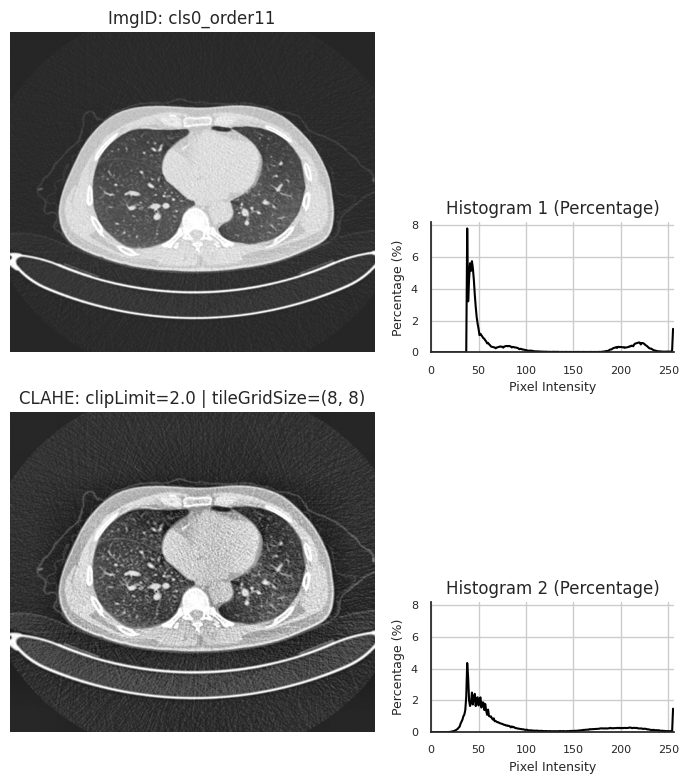

In [18]:
VIZ_CLAHE(img_id="cls0_order1", d_meta=d_meta, clipLimit=2.0, tileGridSize=(8, 8))

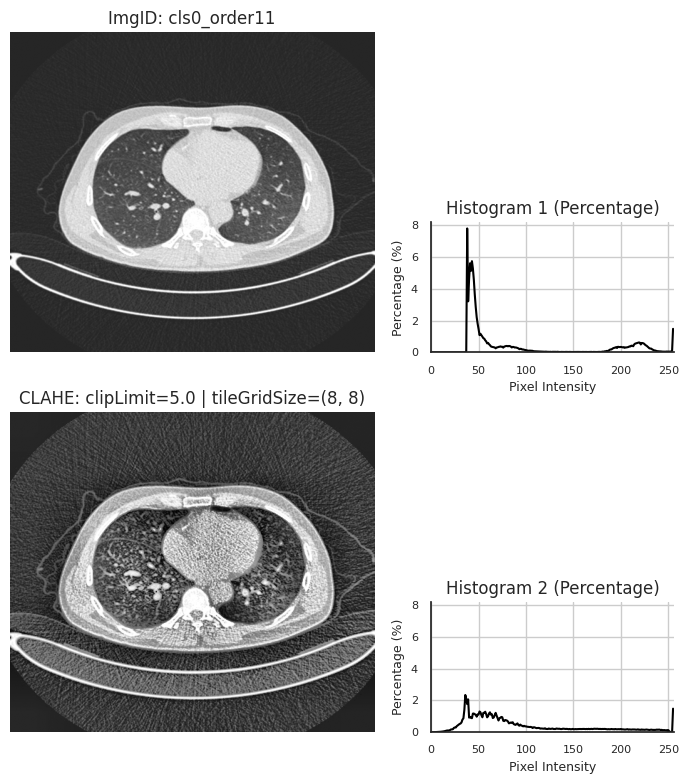

In [19]:
VIZ_CLAHE(img_id="cls0_order1", d_meta=d_meta, clipLimit=5.0, tileGridSize=(8, 8))

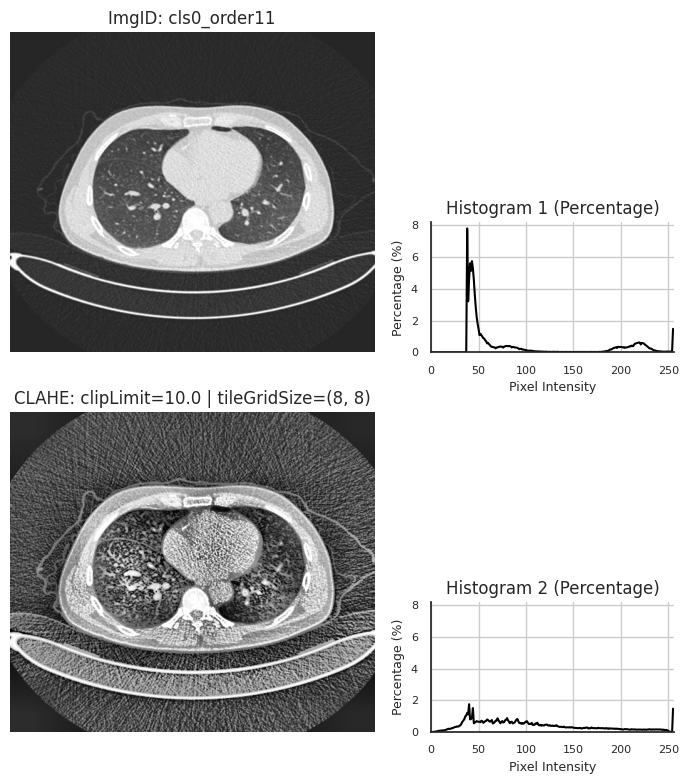

In [20]:
VIZ_CLAHE(img_id="cls0_order1", d_meta=d_meta, clipLimit=10.0, tileGridSize=(8, 8))